In [1]:
# add your drive shortcut to your colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 4.9 MB/s 
     |████████████████████████████████| 7.6 MB 74.4 MB/s 
     |████████████████████████████████| 163 kB 88.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 3.2 MB/s 
     |████████████████████████████████| 1.3 MB 30.0 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=0c6cd84c7ba62772a14a7f170afd681139498c412d9ed9164a3d00bbb2f78831
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import gensim
from nltk.corpus import stopwords

import torch
import torch.nn as nn
from torch.optim import Adam, AdamW
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm, trange

from sentence_transformers import SentenceTransformer

from transformers import (
    BertModel,
    BertTokenizer,
    get_scheduler
)

from sklearn.metrics import (
    precision_score,
    accuracy_score,
    recall_score,
    confusion_matrix, 
    classification_report
)


STOPWORDS = stopwords.words('english')

## Load Data

In [53]:
class SimpleProcessor:
    def __init__(self, news_file, price_file, ticker_name, price_type):
        self.ticker_name = ticker_name
        self.price_type = price_type

        self.crypto_news = pd.read_csv(news_file, index_col=[0])[[ticker_name]]
        self.crypto_news.index = pd.to_datetime(self.crypto_news.index)

        self.price_vol = pd.read_csv(price_file, index_col=[0])
        self.crypto_price = self.price_vol[[ticker_name + '-' + price_type]].shift(1)
        
        # calc daily return data
        self.crypto_price["returns"] = self.crypto_price[self.ticker_name + '-' + self.price_type].pct_change().shift(-1)

        self.crypto_price.index = pd.to_datetime(self.crypto_price.index).tz_convert(None)
        self.crypto_news.index = pd.to_datetime(self.crypto_news.index)

        self.data = None

    def get_data(self):
        # sentiment version
        res = pd.DataFrame(columns=["titles", "summaries", "sentiments"])
        for i in range(len(self.crypto_news)):
            line = eval(self.crypto_news.iloc[i][0])  # str to list
            length = 0
            for elem in line:
                length += len(elem)
            if length == 0:
                continue
            else:
                # preprocess titles and summaries, remove duplicate ones
                titles, summaries = list(set(line[0])), list(set(line[1]))
                titles, summaries = " ".join(titles), " ".join(summaries)
                # average sentiment score
                sentiments = list(set(line[2]))
                for j in range(len(sentiments)):
                    if sentiments[j] == "Somewhat-Bullish":
                        sentiments[j] = 0.5
                    elif sentiments[j] == "Bullish":
                        sentiments[j] = 1
                    elif sentiments[j] == "Somewhat-Bearish":
                        sentiments[j] = -0.5
                    elif sentiments[j] == "Bearish":
                        sentiments[j] = -1
                    else:
                        sentiments[j] = 0
                sentiments = np.mean(sentiments)
                # fill in dataframes
                res.loc[self.crypto_news.index[i]] = titles, summaries, sentiments
        # cat strings
        res["text"] = res["titles"].str.cat(res["summaries"], sep=' ')
        
        # data preprocessing
        self.data = pd.merge(
            res, self.crypto_price, how="left", left_index=True, right_index=True
            )
        self.data = self.data[~self.data.isna().any(axis=1)][["text", "sentiments", "returns"]]
        self.data["text"] = self.remove_stopwords(pd.Series(self.tokenize_text(self.data["text"]))).values
        self.data["class"] = (self.data["sentiments"] > 0).map({True: 1, False: 0})
        return self.data.copy()

    @staticmethod
    def tokenize_text(text):
        for sentence in text:
            yield gensim.utils.simple_preprocess(str(sentence), deacc=True)

    @staticmethod
    def remove_stopwords(text):
        return text.apply(lambda x: [w for w in x if w not in STOPWORDS])

    @staticmethod
    def join_str(df):
        lists = eval(df[0])
        if lists[0]:
            return ' '.join(lists[0])
        return np.nan

In [54]:
class NewsDataset(Dataset): 
    def __init__(self, df, tokenizer):
        self.labels = [i for i in df['class']]
        self.texts = [tokenizer(
            str(text), 
            padding='max_length',
            truncation = True, 
            return_tensors='pt') 
        for text in df['text']
        ]
        
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])
    
    def get_batch_text(self, idx):
        return self.texts[idx]
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_text(idx)
        batch_labels = self.get_batch_labels(idx)
        return batch_texts, batch_labels

In [55]:
sp = SimpleProcessor(
    r"/content/drive/MyDrive/FRE_GY_7871_NLP/data/btc_eth.csv", 
    r"/content/drive/MyDrive/FRE_GY_7871_NLP/data/price_vol.csv", 
    "BTC",
    "close")
data = sp.get_data()

In [56]:
data.text = [" ".join(text) for text in data.text]
data.head()

,text,sentiments,returns,class
2022-03-01 13:00:00,geopolitical risk returns global markets inves...,0.0,0.000856,0
2022-03-02 03:00:00,asian shares slip oil surges russia sanctions ...,0.0,0.004782,0
2022-03-02 08:00:00,business highlights lobbyists leaving rate hik...,-0.5,0.000519,0
2022-03-02 09:00:00,business highlights lobbyists leaving rate hik...,-0.5,0.000185,0
2022-03-02 11:00:00,millions crypto start ups real names necessary...,0.0,-0.000722,0


In [57]:
sp.crypto_price.loc["2022-03-01 13:00:00":]

,BTC-close,returns
2022-03-01 13:00:00,44543.996094,0.000856
2022-03-01 14:00:00,44582.144531,-0.013757
2022-03-01 15:00:00,43968.828125,-0.008081
2022-03-01 16:00:00,43613.503906,-0.006110
2022-03-01 17:00:00,43347.035156,0.006365
...,...,...
2022-09-25 00:00:00,18940.152344,0.001259
2022-09-25 01:00:00,18963.992188,0.000494
2022-09-25 02:00:00,18973.359375,-0.000934
2022-09-25 03:00:00,18955.644531,0.004757


## Model Training

In [58]:
class embeddingClassifier(nn.Module):
    def __init__(self, pre_trained='bert-base-uncased', lstm_layers=2, lr=1e-3):
        super().__init__()
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.bert = BertModel.from_pretrained(pre_trained)
        # frozen parameters (not changing parameters of pretrained models)
        self.bert.requires_grad_(False) 
        self.hidden_size = self.bert.config.hidden_size
        
        self.lstm_layers = lstm_layers
        self.LSTM = nn.LSTM(input_size=self.hidden_size, hidden_size=256, num_layers=lstm_layers, dropout = 0.2)
        
        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(64)

        self.fc1 = nn.Linear(in_features=256, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=1)
        
        self.optimizer = Adam(self.parameters(), lr = lr)
        self.criterion = nn.BCELoss(reduction='sum')
        
    def forward(self, input_id, mask):
        h = torch.zeros((self.lstm_layers, input_id.size(0), 256)).to(self.device)
        c = torch.zeros((self.lstm_layers, input_id.size(0), 256)).to(self.device)
        torch.nn.init.xavier_normal_(h)
        torch.nn.init.xavier_normal_(c)
        
        # [0]: word embeddings, [1]: sentence embeddings
        encoded_layers = self.bert(input_ids=input_id, attention_mask=mask)[0]
        encoded_layers = encoded_layers.permute(1, 0, 2)
        
        out, (hn, cn) = self.LSTM(encoded_layers, (h, c))
        out = out[-1, :, :].view(-1, 256)
        out = self.bn1(out)
        
        out = torch.relu_(self.fc1(out))
        out = self.bn2(out)

        out = torch.sigmoid(self.fc2(out))
        
        return out

In [59]:
def trainer(model, trainLoader, validLoader, epochs):
    #epochs 
    trainloss = []
    validloss = []
    
    model = model.to(model.device)
    print(model.device)
    for _ in trange(epochs):
        
        #set model to training model
        model.train()
        
        total_loss = 0
        total_num = 0
        for train_inputs, train_labels in trainLoader:
            
            train_labels = train_labels.float()
            train_labels = train_labels.to(model.device)
            mask = train_inputs['attention_mask'].to(model.device)
            input_id = train_inputs['input_ids'].squeeze(1).to(model.device) 
            
            
            model.optimizer.zero_grad()

            output = model(input_id, mask)

            loss = model.criterion(output, train_labels.unsqueeze(1))
            loss.backward()
                        
            model.optimizer.step()
            total_loss += loss.item()
            
            total_num += input_id.size(0)
        
        # Validation
        model.eval()
        
        total_loss_val = 0
        total_num_val = 0
        preds = []
        trues = []
        with torch.no_grad():
            
            for valid_inputs, valid_labels in validLoader:
                
                valid_labels = valid_labels.float()
                valid_labels = valid_labels.to(model.device)
                mask = valid_inputs['attention_mask'].to(model.device)
                input_id = valid_inputs['input_ids'].squeeze(1).to(model.device)
                
             
                output = model(input_id, mask)
                
                loss = model.criterion(output, valid_labels.unsqueeze(1))
                
                total_loss_val += loss.item()
                total_num_val += input_id.size(0)

                probs = output.detach().cpu().numpy()
                predictions = [1 if p > 0.5 else 0 for p in probs]
                
                labels = valid_labels.detach().cpu().numpy().flatten()
                
                
                preds += list(predictions)
                trues += list(labels)
        
        
        trainloss.append(total_loss/total_num)
        validloss.append(total_loss_val/total_num_val)
        print('\n\t - Train loss : {:.4f}'.format(total_loss / total_num))
        print('\t - Validation loss : {:.4f}'.format(total_loss_val / total_num_val))
        print('\t - Validation accuracy : {:.4f}'.format(accuracy_score(trues, preds)))
        print('\t - Validation precision : {:.4f}'.format(precision_score(trues, preds)))
        print('\t - Validation recall : {:.4f}'.format(recall_score(trues, preds)))
    
    return trainloss, validloss

In [60]:
def evaluate(model, testLoader):
    model = model.to(model.device)
    preds = []
    with torch.no_grad():
      for test_inputs, test_labels in testLoader:

        test_labels = test_labels.float()
        test_labels = test_labels.to(model.device)
        mask = test_inputs['attention_mask'].to(model.device)
        input_id = test_inputs['input_ids'].squeeze(1).to(model.device)

        output = model(input_id, mask)

        probs = output.detach().cpu().numpy()
        predictions = [1 if p > 0.5 else 0 for p in probs]

        preds += list(predictions)        
    
    return preds

In [61]:
# Train Valid Test Split
percent = 0.8
n = data.shape[0]
trainData, testData = data.iloc[0 : int(n*percent)], data.iloc[int(n*percent):]
m = trainData.shape[0]
trainData, validData = trainData.iloc[0 : int(m*percent)], trainData.iloc[int(m*percent): ]

# Load Sentence Bert Pre-trained Model
BERT_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(BERT_NAME)
trainDataLoader = DataLoader(NewsDataset(trainData, tokenizer), batch_size=32, drop_last=True)
validDataLoader = DataLoader(NewsDataset(validData, tokenizer), batch_size=32, drop_last=True)
testDataLoader = DataLoader(NewsDataset(testData, tokenizer), batch_size=32)

In [62]:
num_epochs = 5
model = embeddingClassifier(lr=1e-4)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [63]:
trainloss, validloss = trainer(model, trainDataLoader, validDataLoader, num_epochs)

cuda


 20%|██        | 1/5 [00:25<01:43, 25.81s/it]


	 - Train loss : 0.6918
	 - Validation loss : 0.6910
	 - Validation accuracy : 0.5391
	 - Validation precision : 0.5623
	 - Validation recall : 0.5269


 40%|████      | 2/5 [00:51<01:17, 25.80s/it]


	 - Train loss : 0.6555
	 - Validation loss : 0.6877
	 - Validation accuracy : 0.5328
	 - Validation precision : 0.5692
	 - Validation recall : 0.4311


 60%|██████    | 3/5 [01:17<00:51, 25.79s/it]


	 - Train loss : 0.6360
	 - Validation loss : 0.6915
	 - Validation accuracy : 0.5172
	 - Validation precision : 0.5561
	 - Validation recall : 0.3713


 80%|████████  | 4/5 [01:43<00:25, 25.78s/it]


	 - Train loss : 0.6156
	 - Validation loss : 0.7008
	 - Validation accuracy : 0.5047
	 - Validation precision : 0.5403
	 - Validation recall : 0.3413


100%|██████████| 5/5 [02:08<00:00, 25.79s/it]


	 - Train loss : 0.5959
	 - Validation loss : 0.7023
	 - Validation accuracy : 0.5172
	 - Validation precision : 0.5776
	 - Validation recall : 0.2784


## Model Validation and Prediction

In [64]:
y_test_pred = evaluate(model, testDataLoader)
y_test_true = list(testData.loc[:, "class"])

In [65]:
y_test_true[:5]

[0, 0, 0, 1, 1]

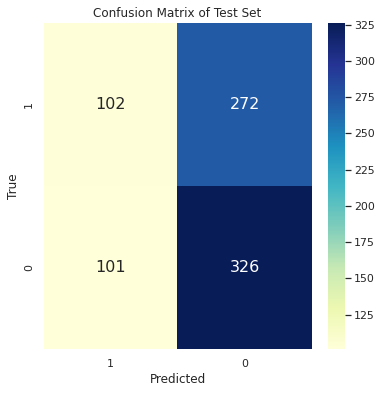

In [66]:
cm_test = confusion_matrix(y_test_true, y_test_pred, labels=[1, 0])
plt.figure(figsize = (6,6))
s = sns.heatmap(cm_test, annot=True, fmt='d', annot_kws={'size': 16}, 
                cmap='YlGnBu', xticklabels=[1, 0], yticklabels=[1, 0])
_ = s.set_xlabel('Predicted')
_ = s.set_ylabel('True')
_ = s.set_title('Confusion Matrix of Test Set')

In [67]:
print(classification_report(y_test_true, y_test_pred, labels = [1, 0]))

              precision    recall  f1-score   support

           1       0.50      0.27      0.35       374
           0       0.55      0.76      0.64       427

    accuracy                           0.53       801
   macro avg       0.52      0.52      0.49       801
weighted avg       0.53      0.53      0.50       801



## Back Testing

In [68]:
class BackTestMetrics:
    def __init__(self, df):
        self.df = df
        self.df_dailyreturn = (df - df.shift(1))/df.shift(1)
        self.N = len(df) - 1
        
    def get_return(self):
        return (np.power(self.df.iloc[-1,:]/self.df.iloc[0,:],365*24/self.N) - 1)[0]
    
    def get_vol(self):
        return (np.std(self.df_dailyreturn)*np.sqrt(365*24))[0]
    
    def get_sharpe(self):
        return (self.get_return()/self.get_vol())
    
    def get_cumReturn(self):
        return (self.df.iloc[-1,:]/self.df.iloc[0,:] - 1)[0]
    
    def get_maxdd(self):
        return ((np.maximum.accumulate(self.df) - self.df)/np.maximum.accumulate(self.df)).max()[0]
    
    def strategy_map(self, ticker, strategy_type):
        map1 = {'ticker': ticker,
        'strategy': strategy_type, 
        'annual_return': self.get_return(),
        'annual_vol': self.get_vol(),
        'annual_sharpe': self.get_sharpe(),
        'cum_return': self.get_cumReturn(),
        'maxDD': self.get_maxdd()}
        
        return map1

In [69]:
def simpleBacktest(backtest, y_pred_test, data):
    
    backtest['signal'] = y_pred_test
    backtest_start_date = backtest.index[0]
    
    allBacktest = data[data.index >= backtest_start_date][['returns']]
    backtestTable = allBacktest.merge(backtest[['signal']], how = 'left', left_index=True, right_index=True)
    backtestTable = backtestTable.fillna(method = 'ffill') # maintain viewpoints
    
    def simpleBacktest(df):
        if(df[1] == 1):
            return df[0]
        return 0.0
    
    backtestTable['realized_returns'] = backtestTable.apply(lambda x: simpleBacktest(x), axis=1)
    backtestTable['strat_nav'] = (1 + backtestTable['realized_returns']).cumprod()
    backtestTable['nav'] = (1 + backtestTable['returns']).cumprod()
    
    return backtestTable

In [71]:
backtestTable = simpleBacktest(testData.copy(), y_test_pred, data.copy())

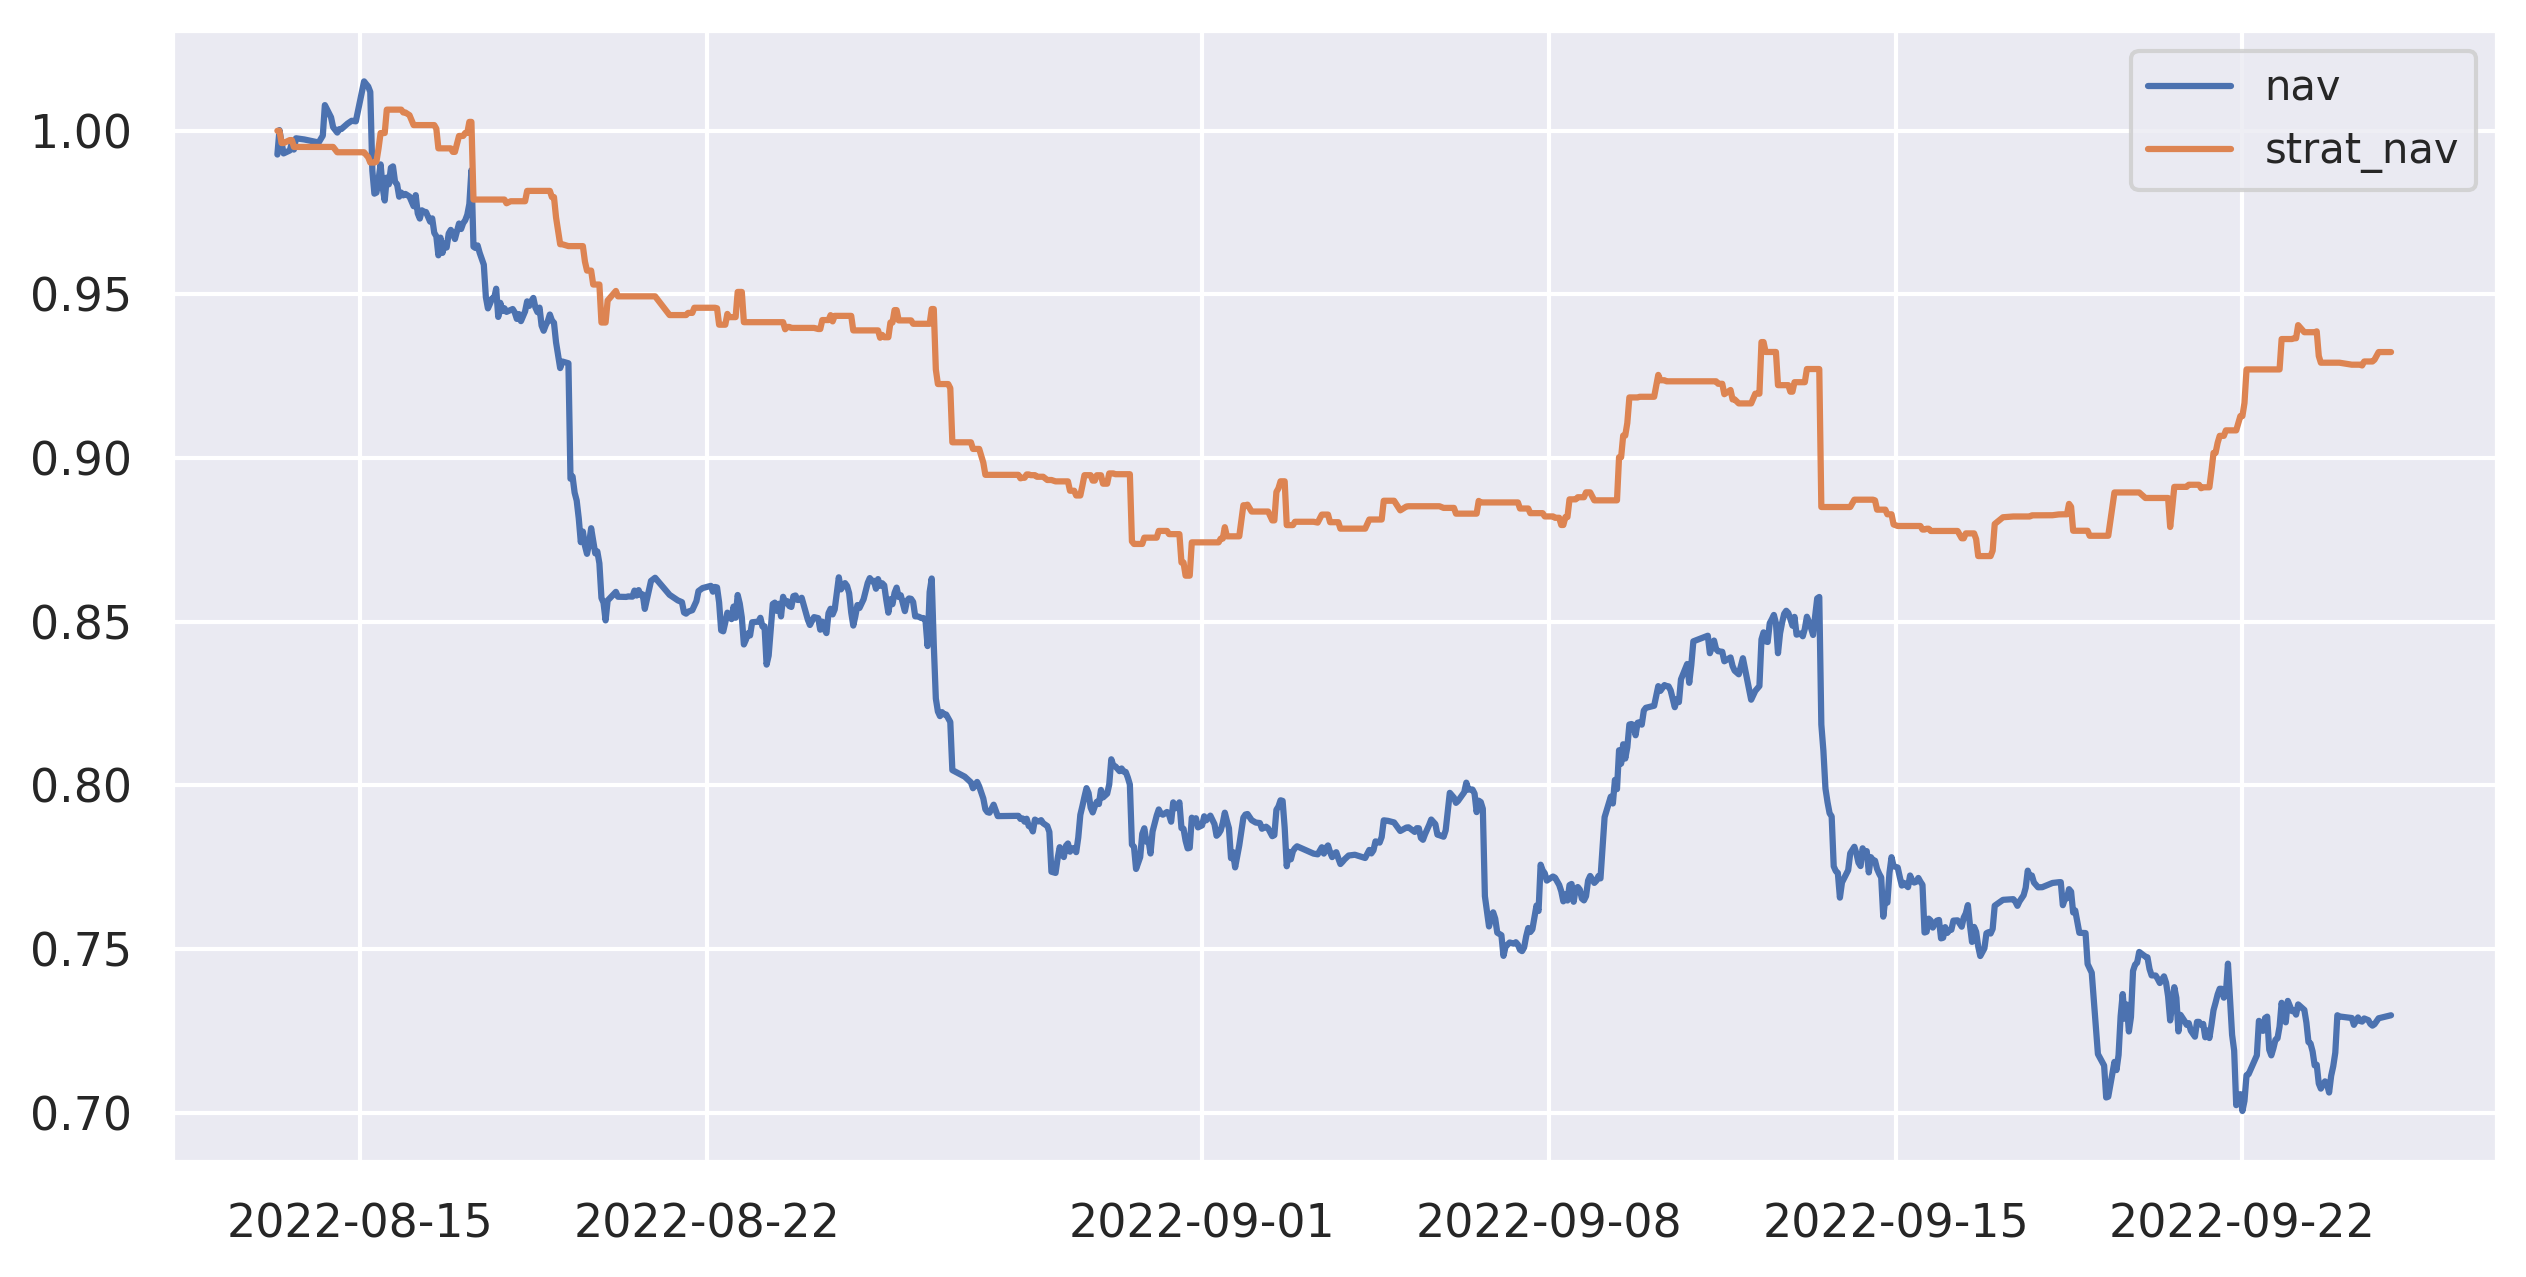

In [72]:
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(backtestTable["nav"], label="nav")
plt.plot(backtestTable["strat_nav"], label="strat_nav")
plt.legend(fontsize=10)
plt.show()